# MAIN NOTEBOOK ~W3Team~

## Imports

In [1]:
import numpy as np
import csv
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import fbeta_score
from sklearn.metrics import accuracy_score

## Compte rendu avec autres groupes:

1. Cost Imbalance:
$$ min(E_{X,Y}L(Y,h(X)))$$
$$<=> min E_{X,Y}[L_{0,1}1_{g(X)>=\alpha}1_{Y=0} + L_{1,0}1_{g(X)<=\alpha}1_{Y=1}]$$
$$<=> min E_{X}[L_{0,1}1_{g(X)>=\alpha}p(y=0|x) + L_{1,0}1_{g(X)<=\alpha}p(y=1|x)]$$

Si le classifieur est calibré cad qu'il renvoie f(x)~p(y=1|x).

Il faut choisir $\alpha$ tel qu $ L_{0,1}p(y=0|x) >= L_{1,0}p(y=1|x) <==> g(x)<\alpha$

$ <==> \frac{f(x)}{1-f(x)}<=\frac{L_{01}}{L_{10}}$

$ <==> f(x)<=\frac{L_{01}}{L_{10}+L_{01}} = \alpha$

1ère solution: on change donc alpha, on change hyperparamètre.

2ème solution: SVM moyen pratique pour vaforiser les 1 ou les 0 (grâce aux pénalités).

2. Missing Data:

Exploration voir si elles ont un sens:(ex: nan//année, nan//colonne, nan//classes)

Si pas de corrélation ==> remplir les nan par des choses qui n'influencent pas mon algo ==> median,moy,regression

3. Categorial(Variables: l'année):

One-hot encoding: 4 colonnes 1 0 0 0, 0 1 0 0, 0 0 1 0, 0 1 1 1

Par le choix des colonnes on choisie à quel point elles sont corrélées, mais on peut faire en sorte que 2014 soit plus corrélée à 2013 si on veut.

En générale est suivie par une PCA sur ($\frac{Xik}{pk} - 1$) pk = proportion d'item qui ont la propriété k

4. Comparing Classifiers:

    * Mean comparison Test

    * Multiple testing



Dataset imbalance:
Missing data: et ils ne sont pas distribué de la même manière entre test et train
data shift:
comparing classifiers:
categorial variables: years

## Data import & analysis

In [2]:
X=np.genfromtxt('X_train.csv')#../input/
y=np.genfromtxt('y_train.csv')

X_test_final=np.genfromtxt('X_test.csv')

print('X shape:',X.shape)
print('X_test_final shape:',X_test_final.shape)

X shape: (8001, 51)
X_test_final shape: (4000, 51)


année 2011, 2001 données


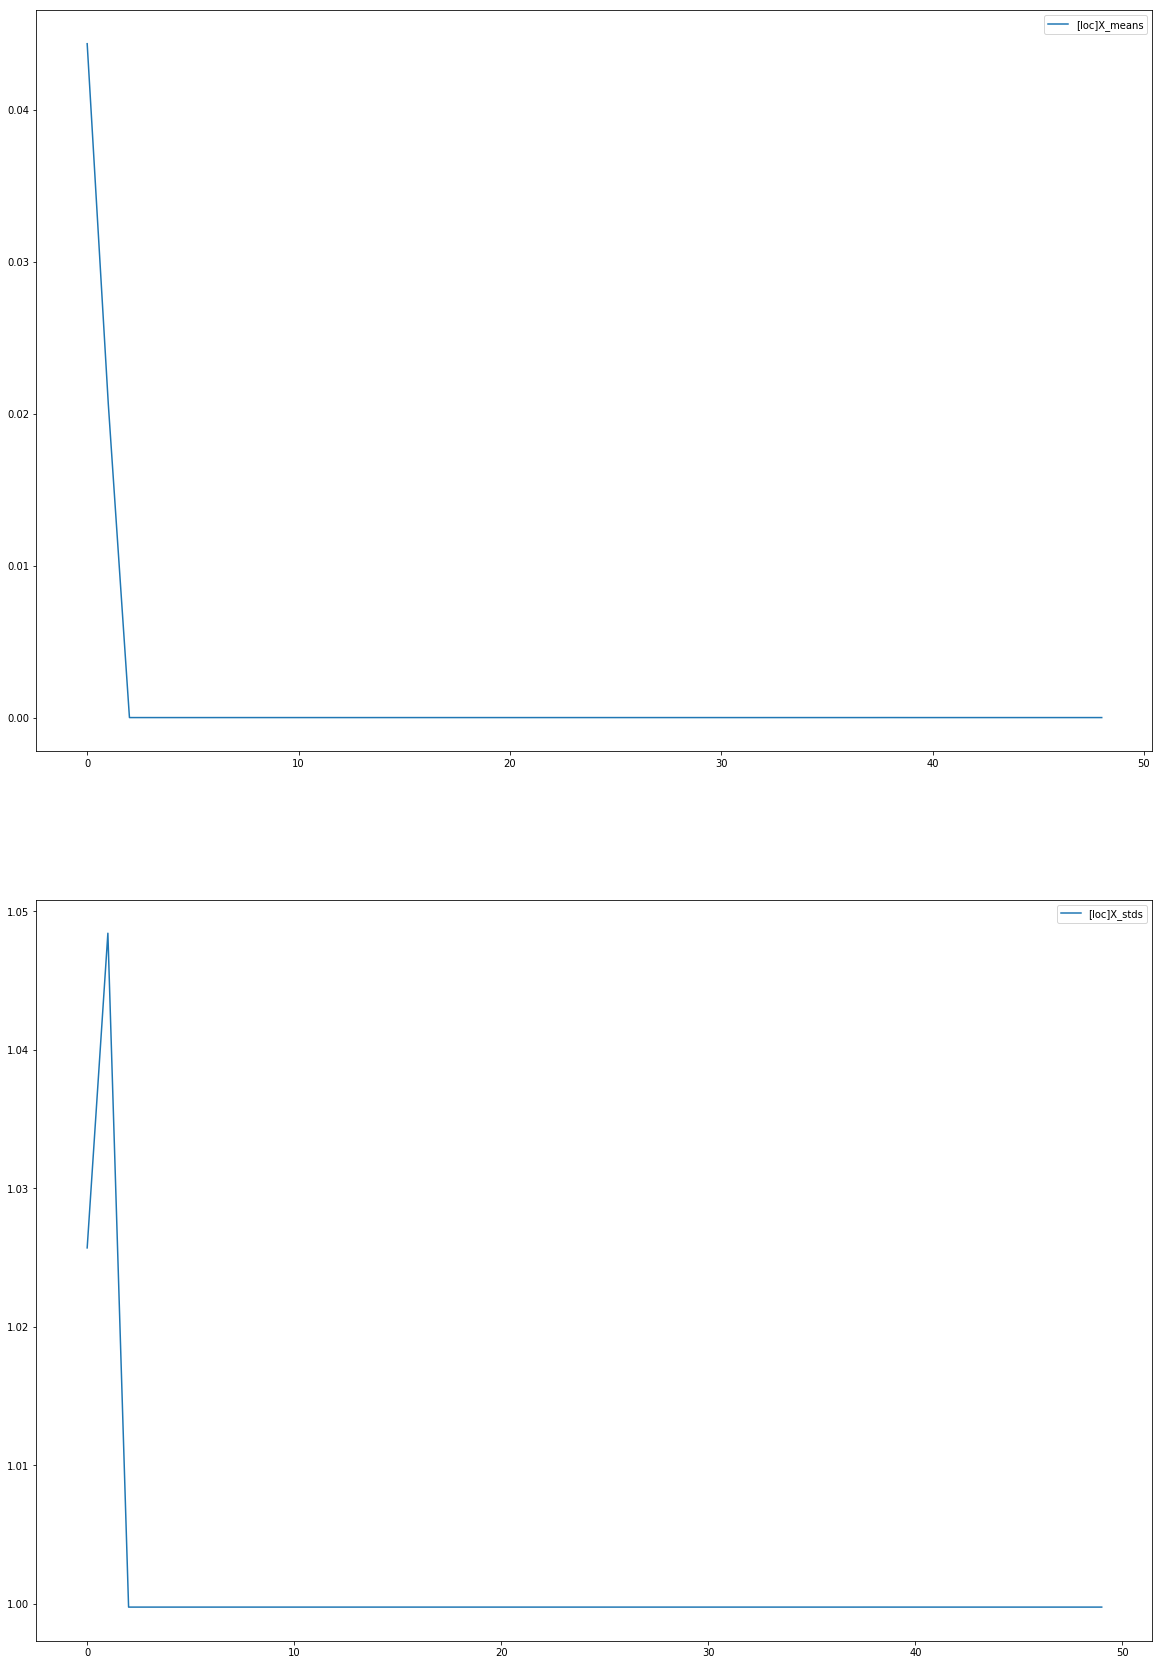

année 2012, 4000 données


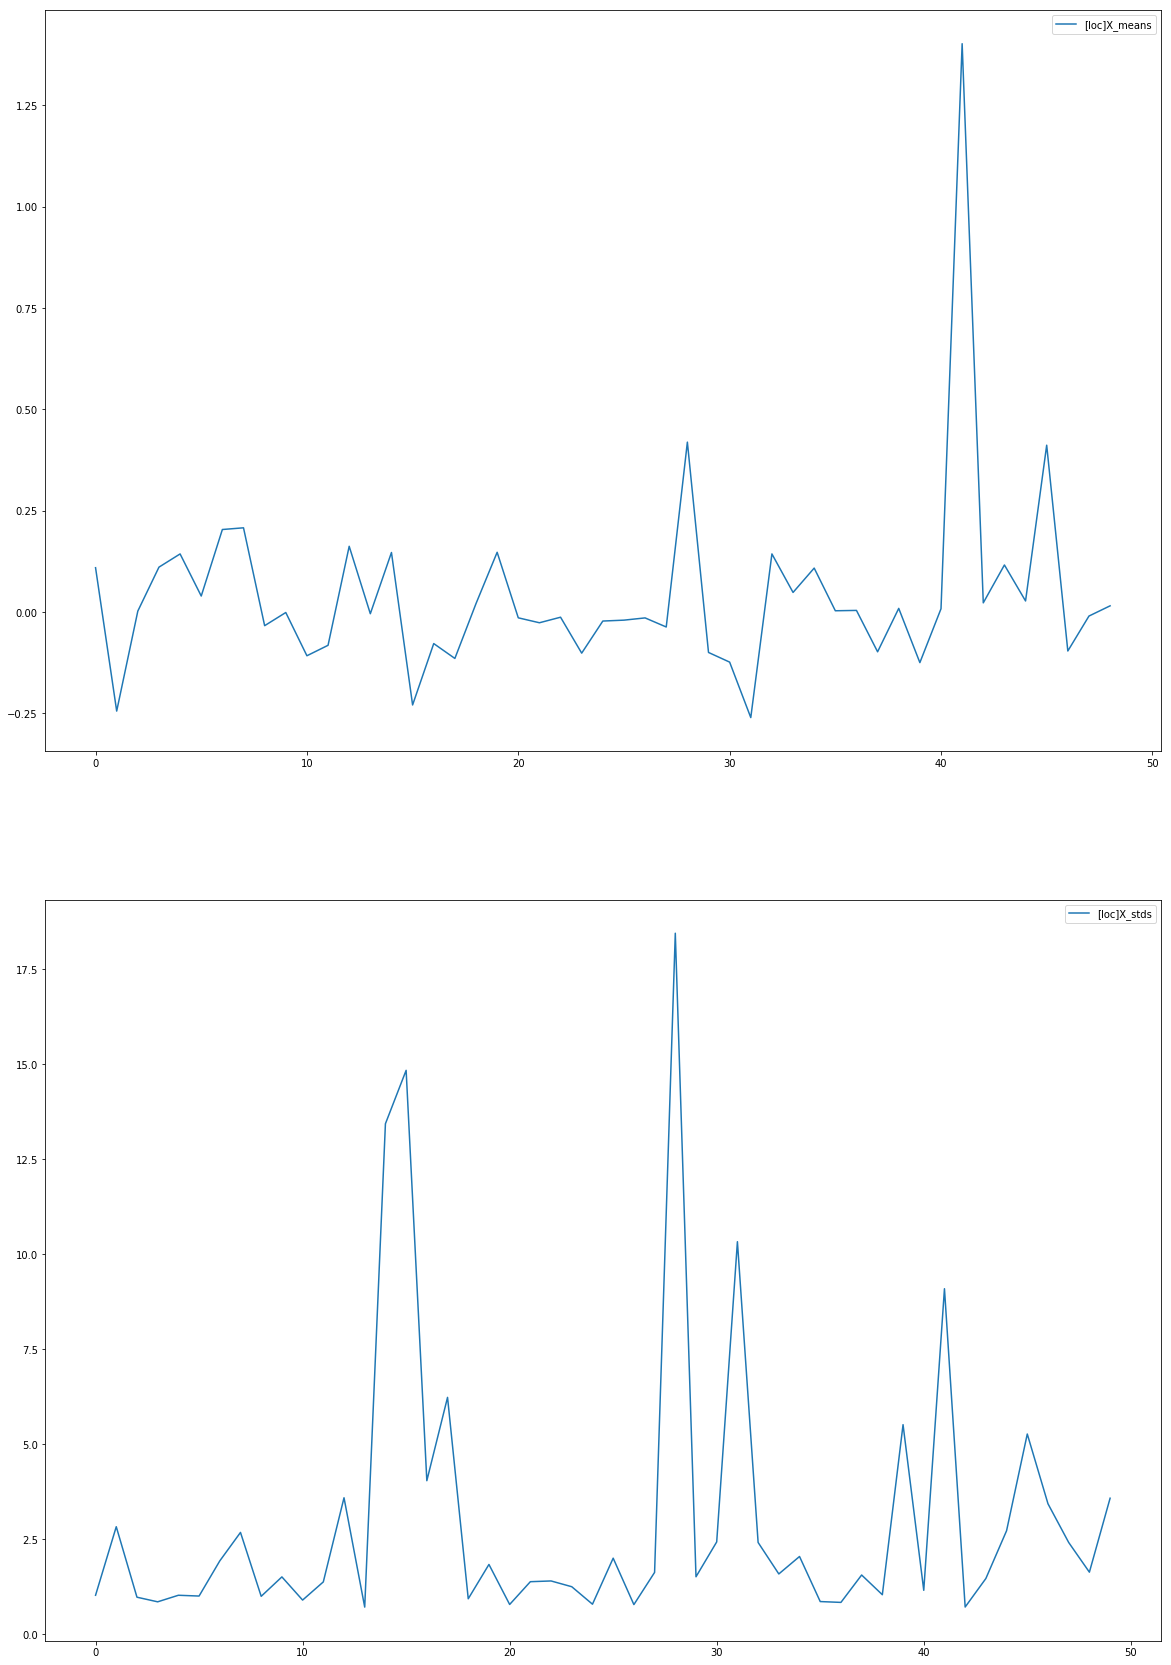

année 2013, local 2000 final 2000 données


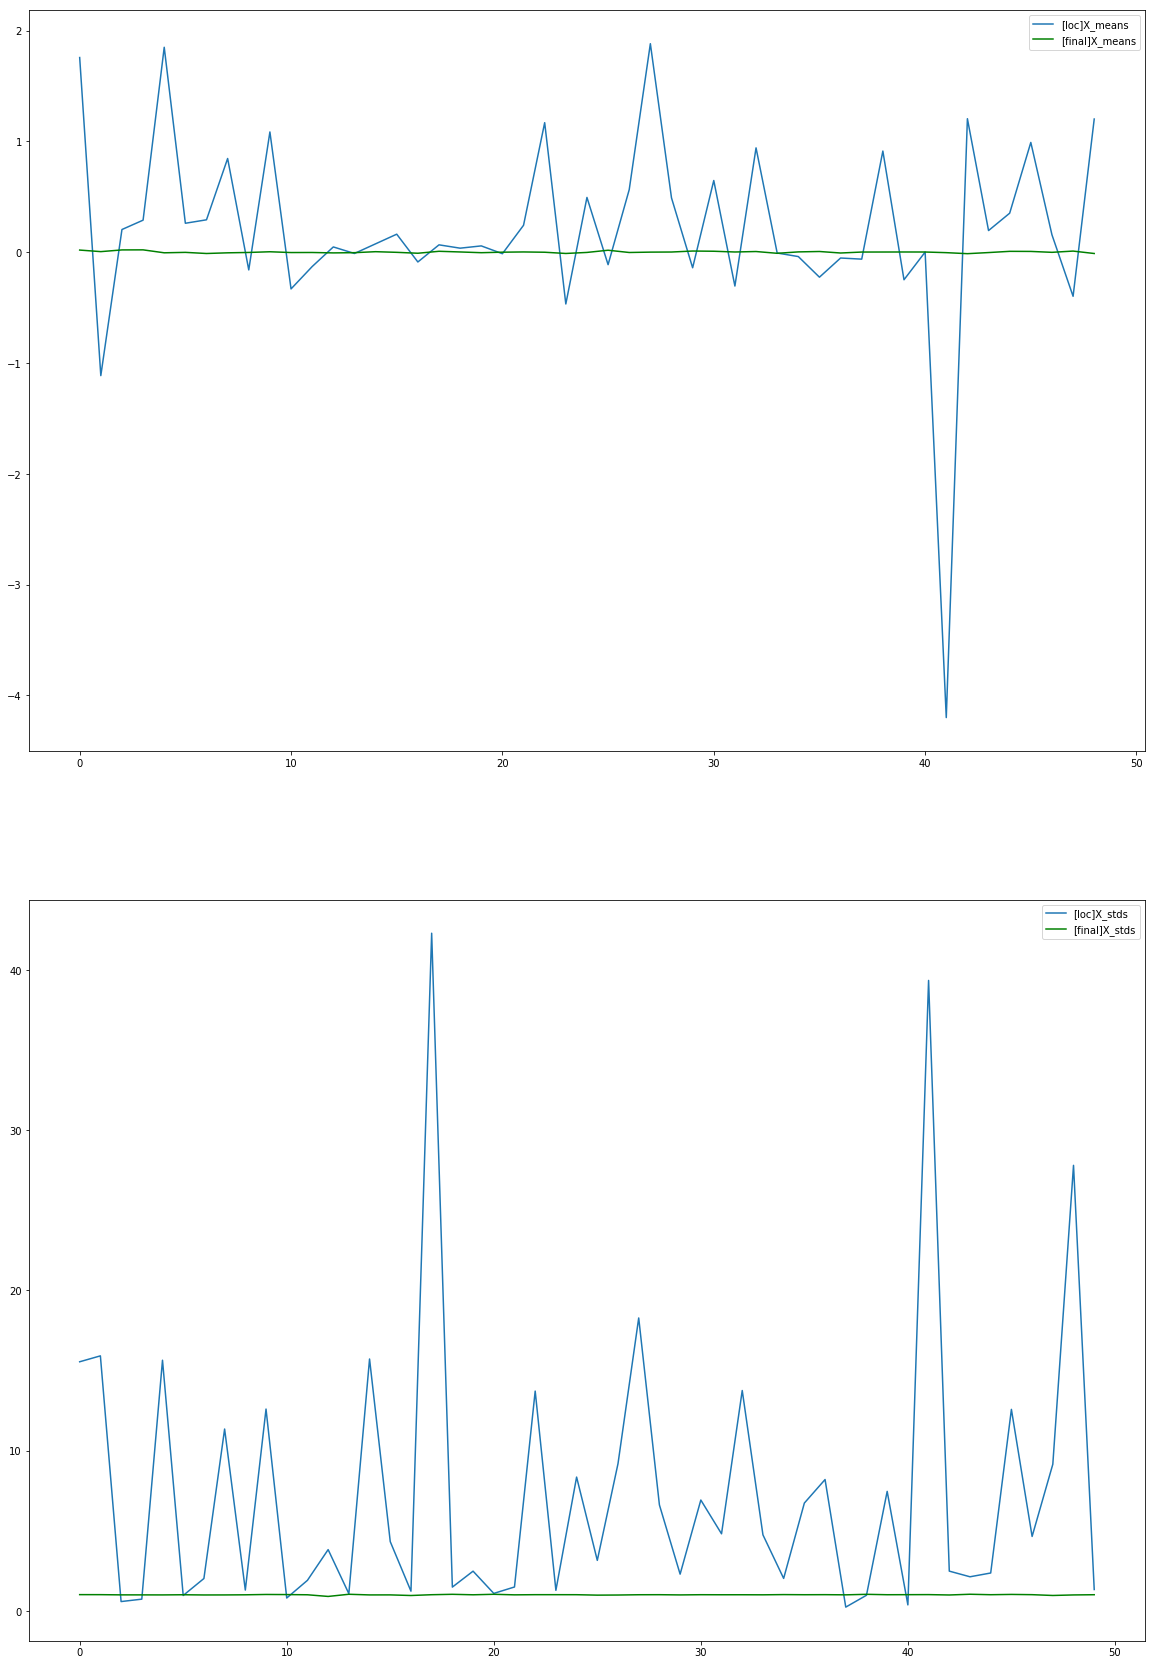

année 2014, 2000 données


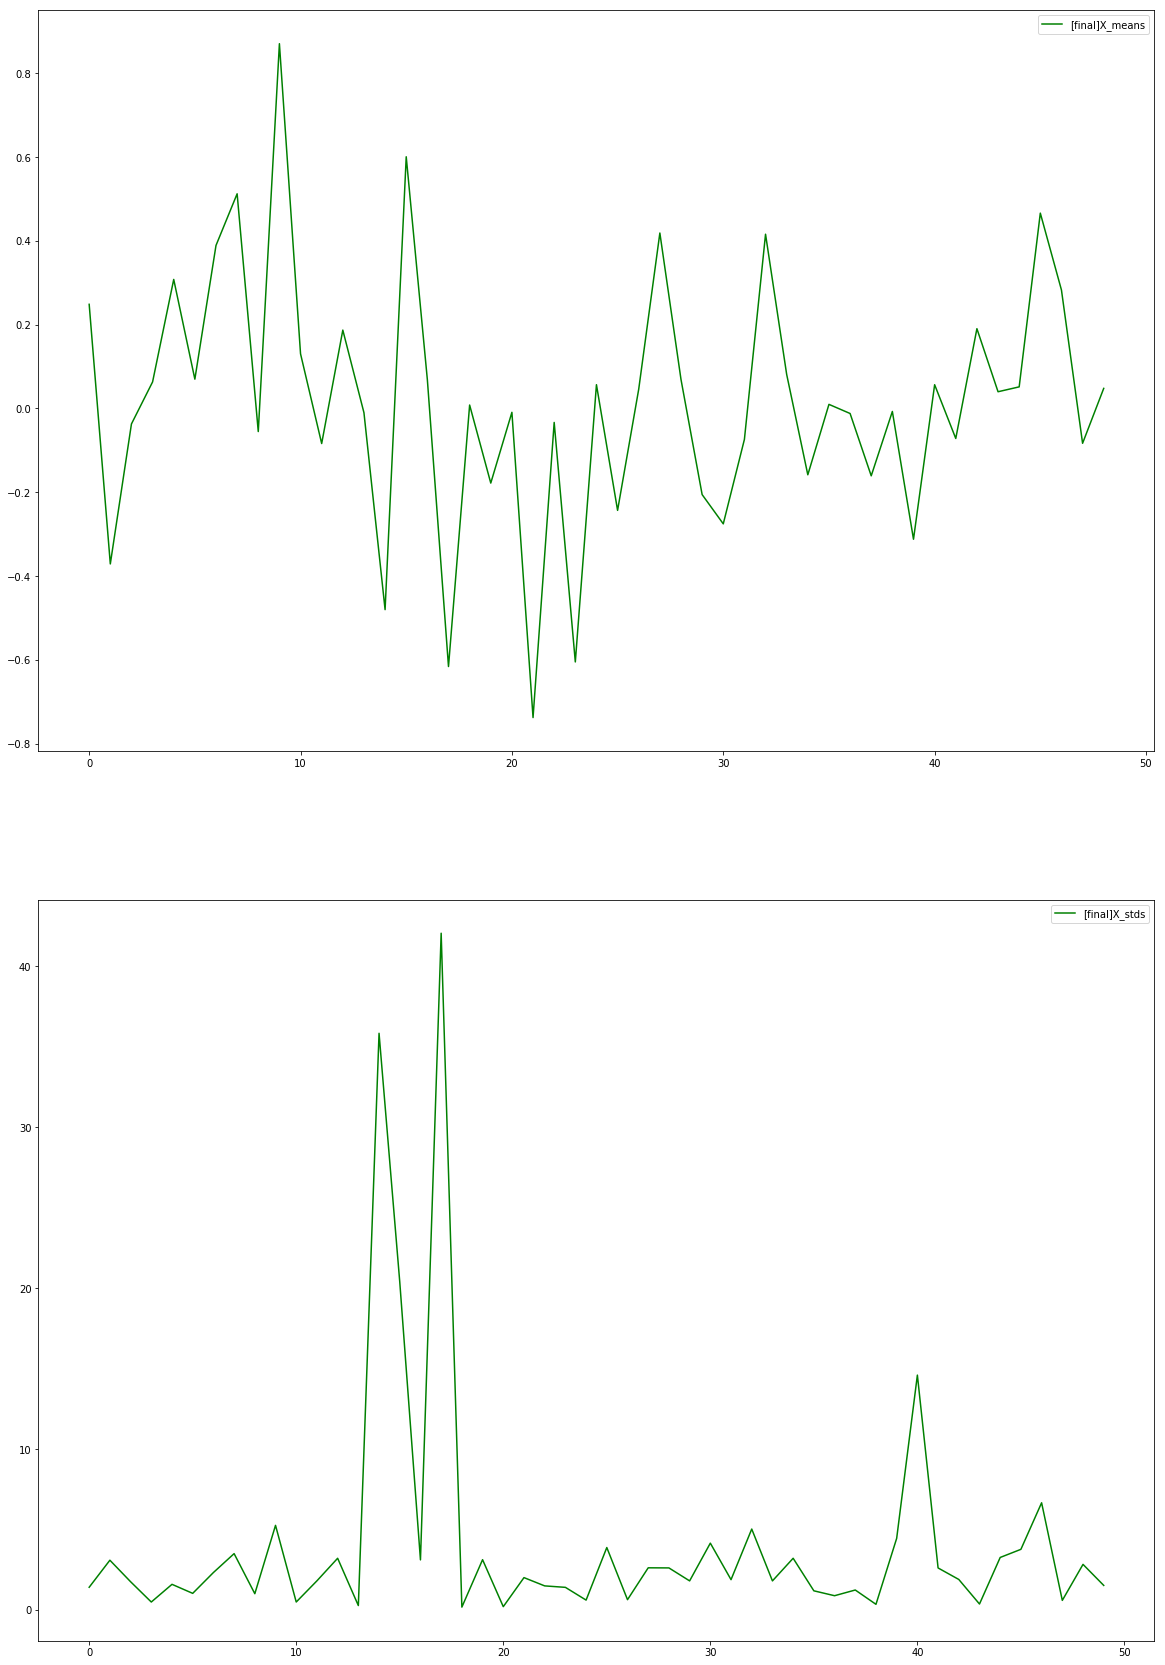

In [3]:
def reportMeanStdLocAndFinal(X,X_test_final):
    reverse=False
    if X is None:
        X=X_test_final
        reverse=True
        X_test_final=None
    if not X_test_final is None:
        X_all=np.concatenate((X,X_test_final))
    else:
        X_all=X
    X_means_loc=np.nanmean(X, axis=0)
    X_stds_loc=np.nanstd(X,axis=0)
    
    if not X_test_final is None:
        X_means_final=np.nanmean(X_test_final, axis=0)
        X_stds_final=np.nanstd(X_test_final,axis=0)
    
    plt.figure(figsize=(20,30))
    plt.subplot(2,1,1)
    if reverse:
        plt.plot(X_means_loc[:-1],'g',label="[final]X_means")
    else:
        plt.plot(X_means_loc[:-1],label="[loc]X_means")
    if not X_test_final is None:
        plt.plot(X_means_final[:-1],'g',label="[final]X_means")
    plt.legend()
    
    plt.subplot(2,1,2)
    if reverse:
        plt.plot(X_stds_loc,'g',label="[final]X_stds")
    else:
        plt.plot(X_stds_loc,label="[loc]X_stds")
    if not X_test_final is None:
        plt.plot(X_stds_final,'g',label="[final]X_stds")
    plt.legend()
    
    plt.show()
    
print('année 2011,',X[X[:,-1]==2011].shape[0],'données')
reportMeanStdLocAndFinal(X[X[:,-1]==2011][:,:-1],None)

print('année 2012,',X[X[:,-1]==2012].shape[0],'données')
reportMeanStdLocAndFinal(X[X[:,-1]==2012][:,:-1],None)

print('année 2013, local',X[X[:,-1]==2013].shape[0],'final',X_test_final[X_test_final[:,-1]==2013].shape[0],'données')
reportMeanStdLocAndFinal(X[X[:,-1]==2013][:,:-1],X_test_final[X_test_final[:,-1]==2013][:,:-1])

print('année 2014,',X_test_final[X_test_final[:,-1]==2014].shape[0],'données')
reportMeanStdLocAndFinal(None,X_test_final[X_test_final[:,-1]==2014][:,:-1])

Les attributs semblent tous de moyenne nulle sauf le dernier où les deux ont une moyenne de 2000 environ (c'est l'année).

En ce qui concerne les écart-types ce n'est pas réduit et on remarque une différence notable entre les données locales et les données test. Cette forte variance explique sans doute la différence notable entre le scoring local et le scoring final.

prop NaN in Test_Final: 0.07093137254901961
prop NaN in Train: 0.013199330475847381
prop line with Nan in Test: 0.362



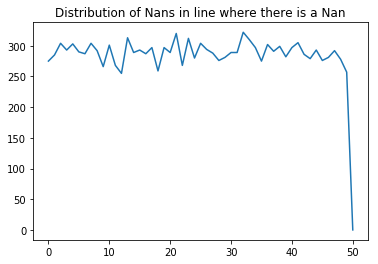

Number of Nan average by line 0.1959430180912144


In [4]:
print("prop NaN in Test_Final:",np.isnan(X_test_final).sum()/(X_test_final.shape[0]*X_test_final.shape[1]))
print("prop NaN in Train:",np.isnan(X).sum()/(X.shape[0]*X.shape[1]))

idxLineWithNan=[]
for i in range(X_test_final.shape[0]):
    if True in np.isnan(X_test_final[i]):
        idxLineWithNan+=[i]

propNan=[0]*X_test_final.shape[1]
for idx in idxLineWithNan:
    isNan_arr=np.isnan(X_test_final[idx])
    for j in range(X_test_final.shape[1]):
        if isNan_arr[j]:
            propNan[j]+=1
print("prop line with Nan in Test:",len(idxLineWithNan)/X_test_final.shape[0])
print()
plt.plot(propNan)
plt.title("Distribution of Nans in line where there is a Nan")
plt.show()
print("Number of Nan average by line",np.sum(propNan[:-1])/(X_test_final.shape[1]*len(idxLineWithNan)))

idée: on peut nanifier les données de notre test pour que ça ressemble au test final.
* chaque ligne a une probabilité 0.07 de se faire nanifier
* si une ligne se fait nanifier: chaque colonne a une probabilité 0.19 de se faire Nanifier

def Nanify(X,propNanLine=0.07, propNanCol=0.195):
    rdLine=np.random.random(X.shape[0])
    
    for line in np.where(rdLine<=propNanLine)[0]:
        rdCol=np.random.random(X.shape[1]-1)
        for col in np.where(rdCol<=propNanCol)[0]:
            X[line,col]=np.nan

X=np.nan_to_num(X)
Nanify(X)
idxLineWithNan=[]
for i in range(X.shape[0]):
    if True in np.isnan(X[i]):
        idxLineWithNan+=[i]

propNan=[0]*X.shape[1]
for idx in idxLineWithNan:
    isNan_arr=np.isnan(X[idx])
    for j in range(X.shape[1]):
        if isNan_arr[j]:
            propNan[j]+=1
print("prop line with Nan in X:",len(idxLineWithNan)/X.shape[0])
print()
plt.plot(propNan)
plt.title("Distribution of Nans in line where there is a Nan")
plt.show()
print("Number of Nan average by line with Nan",np.sum(propNan[:-1])/(X.shape[1]*len(idxLineWithNan)))

## Helper functions

In [5]:
def getTrainTest(X_loc,y_loc,repartition):
    """
    Retourne une répartition train/test aléatoire avec la répartition train/test passé en paramètre
    """
    n=X_loc.shape[0]
    shuffle_arr=np.random.rand(n).argsort()
    delim=int(n//(1/repartition))
    X_loc=np.copy(X_loc)
    y_loc=np.copy(y_loc)
    X2=np.take(X_loc,shuffle_arr,axis=0,out=X_loc)
    y2=np.take(y_loc,shuffle_arr,axis=0,out=y_loc)
    
    X_train=X2[:delim]
    y_train=y2[:delim]
    X_test=X2[delim:]
    y_test=y2[delim:]
    return X_train,y_train,X_test,y_test

def testAccuracy(classifier,X_test,y_test):
    """
    Retourne la précision sur le test.
    """
    return np.mean(np.equal(classifier.predict(X_test),y_test))

def genCSVfinal(classifier,X_test_final,name):
    y_test_final=classifier.predict(X_test_final)
    np.savetxt(name+'.csv',y_test_final)

def returnModifiedDistribution(x,y,proportion_1=1/2):
    """
    Extrait des éléments de x,y (dataset) pour se rapprocher d'une distribution proportion_1
    """
    y_0_idx=np.where(y==0)[0]; y_1_idx=np.where(y==1)[0]
    np.random.shuffle(y_0_idx); np.random.shuffle(y_1_idx)
    
    totn=2*min(len(y_0_idx),len(y_1_idx))
    y_0_idx,y_1_idx=y_0_idx[:int(totn//(1/(1-proportion_1)))],y_1_idx[:int(totn//(1/proportion_1))]
    idx_final=np.concatenate((y_0_idx,y_1_idx))
    np.random.shuffle(idx_final)
    print("real redistribution:",len(y_1_idx)/(len(y_1_idx)+len(y_0_idx)))
    return x[idx_final],y[idx_final]

def arrayToCSV(y,title_file):
    """
    Convertit un array des résultats en un fichier csv dans le format correspondant au challenge
    y: array de 0 signifiant que l'entreprise est saine et 1 sinon
    title_file: nom du fichier de sortie
    """
    fileOut = [0]*(y.shape[0]+1)
    fileOut[0] = "Id,Expected" #Header
    for i in range(y.shape[0]):
        if y[i]==1:
            fileOut[i+1] = str(i)+",True" 
        else:
            fileOut[i+1] = str(i)+",False"
      
    pd.DataFrame(fileOut).to_csv(title_file+".csv",index=False,header=False,sep=" ")
    
def Nanify(X,propNanLine=0.07, propNanCol=0.195):
    rdLine=np.random.random(X.shape[0])
    
    for line in np.where(rdLine<=propNanLine)[0]:
        rdCol=np.random.random(X.shape[1]-1)
        for col in np.where(rdCol<=propNanCol)[0]:
            X[line,col]=np.nan

## Preprocessing des données

### generic data preproc

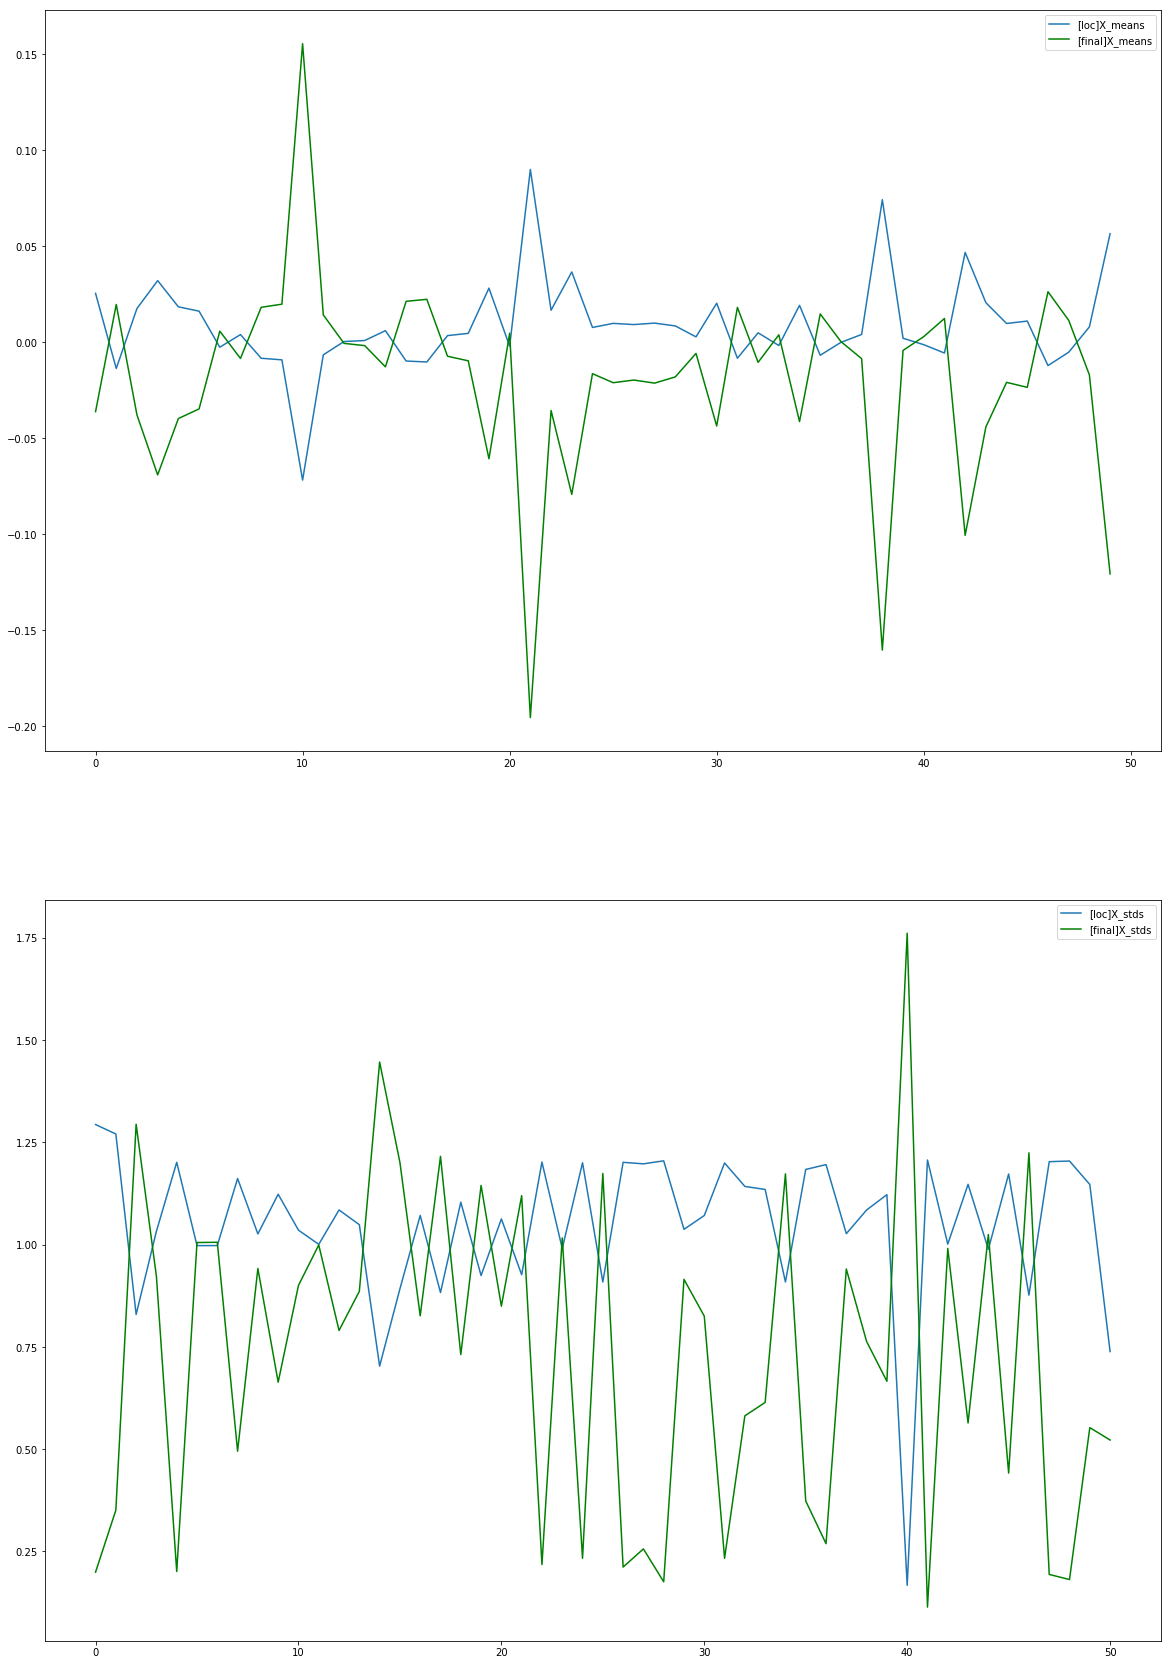

real redistribution: 0.8335416666666666


In [6]:
#std scaling preproc sklearn
X_all=np.concatenate((X,X_test_final))

X_means=np.nanmean(np.concatenate((X,X_test_final)), axis=0)
X_stds=np.nanstd(np.concatenate((X,X_test_final)),axis=0)

X_2=X-X_means;X_2/=X_stds
X_test_final_2=X_test_final-X_means;X_test_final_2/=X_stds

reportMeanStdLocAndFinal(X_2,X_test_final_2)

X_redis,y_redis=returnModifiedDistribution(X_2,y,0.9)
X_train,y_train,X_test,y_test=getTrainTest(X_redis,y_redis,2/3)

# On enlève les deux premières colonnes pour ne pas avoir à gérer les nouveaux NaN
X_train=X_train#[:,2:]
X_test=X_test#[:,2:]
X_test_final_loc=X_test_final_2#[:,2:]

# On enlève les NaN:
X_train,X_test,X_test_final_loc=np.nan_to_num(X_train),np.nan_to_num(X_test),np.nan_to_num(X_test_final_loc)
                     
X_all_prepoc=np.concatenate((X_train,X_test,X_test_final_loc))



### Sélection des meilleurs attributs

plot les vps par index et couper la pca au bon endroit (réduction de la dimension)

* PCA
* FDA : http://goelhardik.github.io/2016/10/04/fishers-lda/ ou https://pythonhosted.org/MLPY/html/fda.html
* LDA: https://stackoverflow.com/questions/23277958/how-to-run-and-interpret-fishers-linear-discriminant-analysis-from-scikit-learn
* Isomap : https://scikit-learn.org/stable/modules/generated/sklearn.manifold.Isomap.html
* CCA : canonical cross decomposition

https://pdfs.semanticscholar.org/0ed0/e48b245f2d459baa3d2779bfc18fee04145b.pdf

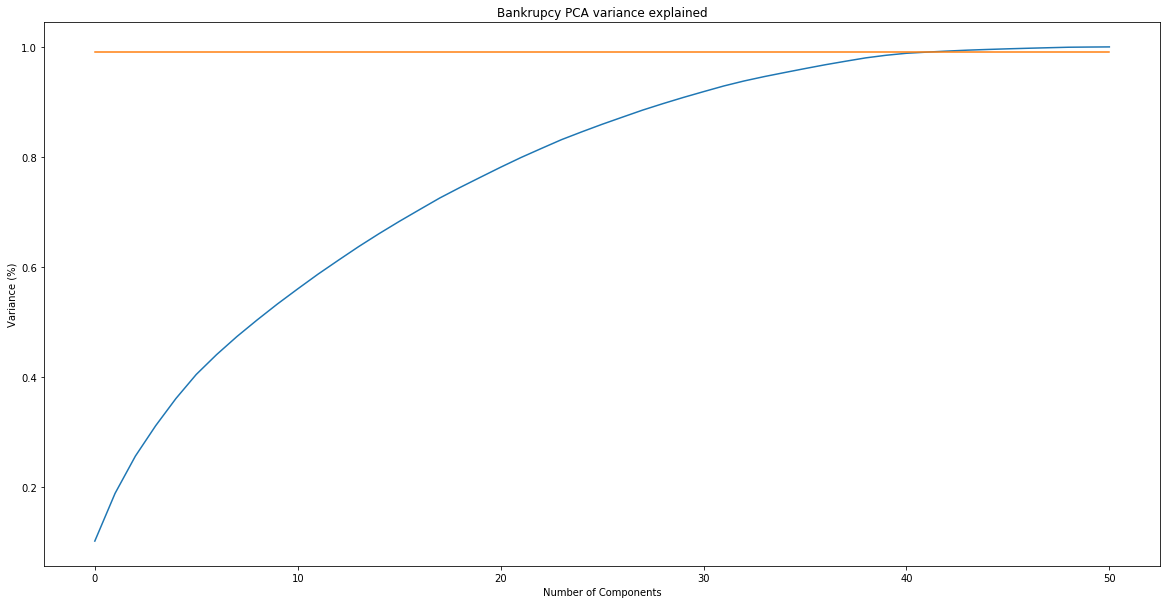

variance apportée par les composantes principales
[0.10173946 0.08685051 0.06763695 0.05524534 0.04951036 0.04365134
 0.03596947 0.0328061  0.03029106 0.02901171 0.02742616 0.0267601
 0.02524955 0.02477899 0.02342026 0.02236143 0.02143435 0.02120669
 0.01917894 0.01847306 0.0182867  0.01759594 0.01639225 0.01612543
 0.01421213 0.01370299 0.01297191 0.0128593  0.01174479 0.01118725
 0.01058343 0.01034204 0.00909111 0.00800267 0.007332   0.00718391
 0.00696133 0.00637475 0.00615316 0.00470801 0.0036305  0.00207288
 0.00187888 0.0016975  0.00126772 0.00116346 0.00103081 0.0009548
 0.00090807 0.00033009 0.00025234]
sommes cumulées des variances apportées par les composantes principales
[0.10173946 0.18858997 0.25622692 0.31147226 0.36098262 0.40463396
 0.44060343 0.47340953 0.50370059 0.5327123  0.56013846 0.58689856
 0.6121481  0.6369271  0.66034736 0.68270879 0.70414314 0.72534983
 0.74452877 0.76300183 0.78128853 0.79888447 0.81527672 0.83140215
 0.84561428 0.85931727 0.87228919 0.88514

In [7]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

#scaler = MinMaxScaler(feature_range=[0, 1])
#data_rescaled = scaler.fit_transform(data[1:, 0:8])

#Fitting the PCA algorithm with our Data
pca = PCA().fit(X_all_prepoc)
#Plotting the Cumulative Summation of the Explained Variance
plt.figure(figsize=(20,10))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.plot([0.99]*51)
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') #for each component
plt.title('Bankrupcy PCA variance explained')
plt.show()
print('variance apportée par les composantes principales')
print(pca.explained_variance_ratio_)
print('sommes cumulées des variances apportées par les composantes principales')
print(np.cumsum(pca.explained_variance_ratio_))

## Entraînement de modèles

### random forest

In [9]:
from sklearn.ensemble import RandomForestClassifier

################### Pour enlever le preproc des données: et on fait un traitement custom
X_train,y_train,X_test,y_test=getTrainTest(np.nan_to_num(X[:,:-1]),y,2/3)
X_test_final_loc=np.nan_to_num(X_test_final[:,:-1])
#pca = PCA(50)
#pca.fit(np.nan_to_num(np.concatenate((X[:,:-1],X_test_final[:,:-1]))))
#X_train,X_test=pca.transform(X_train),pca.transform(X_test)
#X_test_final_loc=pca.transform(X_test_final_loc)
###################

rf = RandomForestClassifier(n_jobs=2, random_state=0)
rf.fit(X_train, y_train)
arrayToCSV(rf.predict(X_test_final_loc),'[W3Team]rf avec normalisation sur tout X local')

C:\Users\Thomas\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [10]:
#redis_X_test,redis_y_test=returnModifiedDistribution(X_test,y_test,0.9)
y_pred=rf.predict(X_test)

print('classifier accuracy:',accuracy_score(y_pred,y_test))
#print('f score:',f1_score(y_pred,y_test))
#print('recall score:',recall_score(y_pred,y_test))
print('f_beta2 score:',fbeta_score(y_pred,y_test,beta=2))

classifier accuracy: 0.9861267341582303
f_beta2 score: 0.9895131086142323


In [11]:
#0.84646 sans les deux premières colonnes et avec normalisation sur tout X
#classifier accuracy: 0.9898762654668166
#f_beta2 score: 0.9917733089579526

### Deep neural net

#### Dropout
The original paper on Dropout provides experimental results on a suite of standard machine learning problems. As a result they provide a number of useful heuristics to consider when using dropout in practice.

* Generally, use a small dropout value of 20%-50% of neurons with 20% providing a good starting point. A probability too low has minimal effect and a value too high results in under-learning by the network.
* Use a larger network. You are likely to get better performance when dropout is used on a larger network, giving the model more of an opportunity to learn independent representations.
* Use dropout on incoming (visible) as well as hidden units. Application of dropout at each layer of the network has shown good results.
* Use a large learning rate with decay and a large momentum. Increase your learning rate by a factor of 10 to 100 and use a high momentum value of 0.9 or 0.99.
* Constrain the size of network weights. A large learning rate can result in very large network weights. Imposing a constraint on the size of network weights such as max-norm regularization with a size of 4 or 5 has been shown to improve results.

#### N hiddden units
La différence de performance d'un réseau de neurones avec plus d'une couche cachée est rarement élevée (de plus l'entrraînement devient très difficile). Une première approche est:
* 1 couche cachée, le nombre de neurones dans cette couche est la moyenne du nombre de neurones dans l'input et l'output (ou 2/3 du nombre d'entrée + le nombre de sortie ou $N_h=\sqrt{n\times m}$)

Un majorant du nombre de neurones dans la couche cachée pour éviter de l'overfit est:
$$
N_h\le\frac{N_s}{\alpha\times(N_i+N_o)}
$$
avec $N_i$ le nombre de neurones d'entrée, $N_o$ le nombre de neurones de sortie, $N_s$ le nombre d'exemples dans l'entraînement et $\alpha$ un facteur multiplicatif arbitraire pris entre $2$ et $10$.

In [12]:
Ns=X_train.shape[0]
Ni=X_train.shape[1]
No=1
print('upper bound:',Ns/(2*(Ni+No)))
print('moyenne input/output:',Ni/2+No/2)
Nh=26
#print('moyenne sqrt:',np.math.sqrt(No*Ns))

upper bound: 52.294117647058826
moyenne input/output: 25.5


In [13]:
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Flatten,Dropout
from tensorflow.python.keras.optimizers import Adam

In [14]:
def returnBaselineModel():
    #input_dim=60 pour le premier si dense input_shape=(60,) si dropout
    model = Sequential()
    #model.add(Dropout(0.2, input_shape=(60,)))
    model.add(Dense(Nh, activation='relu'))
    #model.add(Dropout(0.2, input_shape=(60,)))
    model.add(Dense(No, activation='sigmoid'))
    return model

def returnDropoutModel():
    #input_dim=60 pour le premier si dense input_shape=(60,) si dropout
    model = Sequential()
    model.add(Dropout(0.2))
    model.add(Dense(Nh, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(No, activation='sigmoid'))
    return model


#model = returnBaselineModel()
model = returnDropoutModel()

#optimizer = Adam(lr=1e-2) for dropout
optimizer = Adam(lr=1e-3)
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

X_train,y_train,X_test,y_test=getTrainTest(np.nan_to_num(X[:,:-1]),y,2/3)
X_test_final_loc=np.nan_to_num(X_test_final[:,:-1])

In [15]:
model.fit(x=X_train,
          y=y_train,
          epochs=20, batch_size=1,verbose=2)
y_pred=np.rint(model.predict(X_test))

print('classifier accuracy:',accuracy_score(y_pred,y_test))
print('f_beta2 score:',fbeta_score(y_pred,y_test,beta=2))

Epoch 1/20
 - 4s - loss: 0.2738 - acc: 0.9280
Epoch 2/20
 - 4s - loss: 0.1302 - acc: 0.9678
Epoch 3/20
 - 4s - loss: 0.1040 - acc: 0.9741
Epoch 4/20
 - 4s - loss: 0.0899 - acc: 0.9775
Epoch 5/20
 - 4s - loss: 0.0796 - acc: 0.9807
Epoch 6/20
 - 4s - loss: 0.0738 - acc: 0.9822
Epoch 7/20
 - 4s - loss: 0.0761 - acc: 0.9839
Epoch 8/20
 - 4s - loss: 0.0558 - acc: 0.9871
Epoch 9/20
 - 4s - loss: 0.0593 - acc: 0.9884
Epoch 10/20
 - 4s - loss: 0.0478 - acc: 0.9904
Epoch 11/20
 - 3s - loss: 0.0458 - acc: 0.9914
Epoch 12/20
 - 3s - loss: 0.0454 - acc: 0.9927
Epoch 13/20
 - 4s - loss: 0.0424 - acc: 0.9929
Epoch 14/20
 - 4s - loss: 0.0531 - acc: 0.9903
Epoch 15/20
 - 4s - loss: 0.0467 - acc: 0.9923
Epoch 16/20
 - 4s - loss: 0.0405 - acc: 0.9936
Epoch 17/20
 - 4s - loss: 0.0374 - acc: 0.9946
Epoch 18/20
 - 4s - loss: 0.0410 - acc: 0.9934
Epoch 19/20
 - 4s - loss: 0.0393 - acc: 0.9951
Epoch 20/20
 - 4s - loss: 0.0391 - acc: 0.9942
classifier accuracy: 0.9775028121484814
f_beta2 score: 0.980348369807

In [33]:
y_pred=np.rint(model.predict(X_test))

print('classifier accuracy:',accuracy_score(y_pred,y_test))
#print('f score:',f1_score(y_pred,y_test))
#print('recall score:',recall_score(y_pred,y_test))
print('f_beta2 score:',fbeta_score(y_pred,y_test,beta=2))

classifier accuracy: 0.9775028121484814
f_beta2 score: 0.98034836980795


In [34]:
arrayToCSV(np.rint(model.predict(X_test_final_loc)),'[W3Team]mlp dropout 0.2 0.2 no data preprox')

In [80]:
#model.save('0.986875,0.99095,all-30-0.3-0.2[500]')
#model.save('0.99125,0.994704,all-30-0.2-0.2[500]') # -> 0.83927
# no data preproc, 0.2 0.2 dropout -> 0.7859

In [89]:
from keras.models import load_model
model=load_model('0.99125,0.994704,all-30-0.2-0.2[500].h5')
y_pred=np.rint(model.predict(X_test_final_loc))
arrayToCSV(y_pred,'[W3Team]mlp avec dropout 0.2,0.2 (0.99 local)')

### Neural net génétique ou trouver le meilleur réseau

Les paramètres optimaux à trouver sont:
* $N_h$ (entre 1 et le nombre d'entrées)
* facteur dropout entrée (0,0.1,0.2,0.3,0.4,0.5,0.6)
* facteur dropout après couche sortie (0,0.1,0.2,0.3,0.4,0.5,0.6)
* différentes activations pour sortie ('relu' ou 'softmax')
* différentes activations pour couche cachée ('relu' ou 'softmax')

En tout il y aurait $9 996$ modèles à essayer en considérant les activations dfférentes ou $2 499$ en laissant les activations par défaut.

Il faudrait 3-4h pour tester tous les modèles et sélectionner les meilleurs (pas forcément besoin de l'algo génétique..)

## Zone expérimentale

In [35]:
class dummyClassifier():
    def __init__(self):
        pass
    def predictAll0(self,x_toPred):
        return np.array([0]*x_toPred.shape[0])
    def predictAll1(self,x_toPred):
        return np.array([1]*x_toPred.shape[0])
    def predict5050(self,x_toPred):
        return np.random.randint(0,2,size=x_toPred.shape[0])

    
redis_X_test,redis_y_test=returnModifiedDistribution(X_test,y_test,0.9)
y_pred=dummyClassifier().predictAll0(redis_X_test)
#print('[ALL0]classifier accuracy:',accuracy_score(y_pred,redis_y_test))
print('[ALL0]f score:',f1_score(y_pred,redis_y_test))
print('[ALL0]recall score:',recall_score(y_pred,redis_y_test))
print('[ALL0]f_beta2 score:',fbeta_score(y_pred,redis_y_test,beta=2))
print()
y_pred=dummyClassifier().predictAll1(redis_X_test)
#print('[ALL1]classifier accuracy:',accuracy_score(y_pred,redis_y_test))
print('[ALL1]f score:',f1_score(y_pred,redis_y_test))
print('[ALL1]recall score:',recall_score(y_pred,redis_y_test))
print('[ALL1]f_beta2 score:',fbeta_score(y_pred,redis_y_test,beta=2))
print()
y_pred=dummyClassifier().predict5050(redis_X_test)
#print('[5050]classifier accuracy:',accuracy_score(y_pred,redis_y_test))
print('[5050]f score:',f1_score(y_pred,redis_y_test))
print('[5050]recall score:',recall_score(y_pred,redis_y_test))
print('[5050]f_beta2 score:',fbeta_score(y_pred,redis_y_test,beta=2))

real redistribution: 0.8377708978328173
[ALL0]f score: 0.0
[ALL0]recall score: 0.0
[ALL0]f_beta2 score: 0.0

[ALL1]f score: 0.9117250673854448
[ALL1]recall score: 0.8377708978328173
[ALL1]f_beta2 score: 0.8658645846665813

[5050]f score: 0.6244218316373729
[5050]recall score: 0.8343634116192831
[5050]f_beta2 score: 0.7354543473523645


C:\Users\Thomas\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\Thomas\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


In [32]:
nbrFailliteNan = 0
nbrFailliteNonNan = 0
nbrNonFailliteNan = 0
nbrNonFailliteNonNan = 0

for i in range(X.shape[0]):
    if y[i]==1 and np.isnan(X[i,0]):
        nbrFailliteNan += 1
    elif y[i]==1:
        nbrFailliteNonNan +=1
    elif y[i]==0 and np.isnan(X[i,0]):
        nbrNonFailliteNan +=1
    else:
        nbrNonFailliteNonNan += 1
print(nbrFailliteNan/(nbrFailliteNonNan+nbrFailliteNan), nbrFailliteNan/(nbrNonFailliteNan+nbrFailliteNan))

0.3784053986503374 0.5621982918678055


Lorsqu'on obtient un nan sur les deux premières colonnes, on a 56% de chances que ça soit une entreprise en faillite, ce n'est pas significatif pour tirer une conclusionsur la présence de ces "nan".